In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import more_itertools as mit

In [2]:
from libs.solution.initial_solution_creators.heuristic import *
from libs.solution.initial_solution_creators.random import *
from libs.utils.matrix import extend_cost_mx
from libs.optimizers.algorithms.genetic.operators.fixers import *
from libs.optimizers.algorithms.genetic.operators.mutations import *
from libs.optimizers.algorithms.genetic.operators.crossovers import *
from libs.environment.cost_calculators import *
from libs.optimizers.algorithms.genetic.population.parent_selectors import *
from libs.optimizers.algorithms.genetic.population.natural_selection import *

In [3]:
rng = np.random.default_rng()
initial_vx = 0
forbidden_val = -1
salesman_n = 3
vehicle_volume = 10
fix_max_add_iters = 100
fix_max_retries = 1
forbidding_p = 0.15
default_quantity = 0.1

<AxesSubplot:>

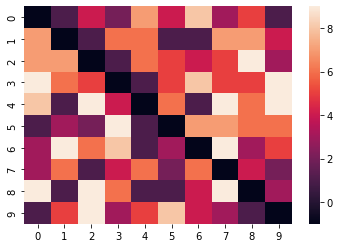

In [4]:
N = 10
dist_mx = rng.integers(1, 10, size=(N, N))
np.fill_diagonal(dist_mx, forbidden_val)
sns.heatmap(dist_mx)

<AxesSubplot:>

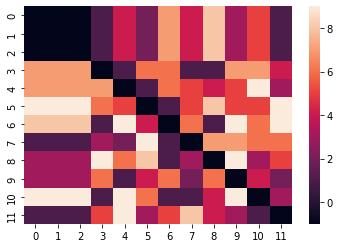

In [5]:
ext_dist_mx = extend_cost_mx(dist_mx, copy_n=salesman_n - 1, to_copy_ix=0)
ini_and_dummy_vxs = {initial_vx, *range(salesman_n)}
sns.heatmap(ext_dist_mx)

## Solution generators

In [6]:
sol_tsp_r, rng = create_tsp_sol_rand(dist_mx, initial_vx, rng)
sol_tsp_r, check_chromosome_tsp(sol_tsp_r, dist_mx, initial_vx, forbidden_val)

([0, 9, 3, 7, 1, 8, 4, 5, 2, 6, 0], True)

In [7]:
sol_tsp_h = create_tsp_sol_nn(dist_mx, initial_vx, forbidden_val)
sol_tsp_h, check_chromosome_tsp(sol_tsp_h, dist_mx, initial_vx, forbidden_val)

([0, 1, 4, 7, 8, 6, 3, 5, 2, 9, 0], True)

In [8]:
sol_vrp_r, rng = create_vrp_sol_rand(
    ext_dist_mx, initial_vx, rng, ini_and_dummy_vxs, regular_vx_division=True
)
sol_vrp_r, check_chromosome_tsp(sol_vrp_r, ext_dist_mx, initial_vx, forbidden_val)

([0, 8, 6, 9, 1, 3, 7, 10, 2, 5, 4, 11, 0], True)

In [9]:
sol_vrp_h = create_tsp_sol_nn(ext_dist_mx, initial_vx, forbidden_val)
sol_vrp_h, check_chromosome_tsp(sol_vrp_h, ext_dist_mx, initial_vx, forbidden_val)

([0, 3, 6, 9, 10, 1, 5, 2, 8, 7, 4, 11, 0], True)

In [10]:
sol_irp_seq_r, sol_irp_qs_r, rng = create_irp_sol_rand(
    ext_dist_mx,
    initial_vx,
    rng,
    ini_and_dummy_vxs,
    vehicle_volume,
    regular_vx_division=True,
)
sol_irp_seq_r, sol_irp_qs_r.tolist(), check_chromosome_tsp(
    sol_irp_seq_r, ext_dist_mx, initial_vx, forbidden_val
)

([0, 4, 3, 9, 1, 5, 11, 8, 2, 6, 7, 10, 0],
 [0.0,
  1.3127910455865226,
  1.8108672071360188,
  0.3534644312632214,
  0.0,
  1.877384225467684,
  1.9358824391183136,
  0.983196328975084,
  0.0,
  1.0491267683501249,
  0.4379214894648119,
  0.23936606463821802,
  0.0],
 True)

In [11]:
mask = rng.random(size=dist_mx.shape) < forbidding_p
mask_ext = rng.random(size=ext_dist_mx.shape) < forbidding_p
masked_dist_mx = dist_mx.copy()
masked_ext_dist_mx = ext_dist_mx.copy()
masked_dist_mx[mask] = forbidden_val
masked_ext_dist_mx[mask_ext] = forbidden_val

## Fixers

In [12]:
from time import perf_counter


def fixer_check_tsp(
    masked_dist_mx: np.ndarray, rng: np.random.Generator, iter_n: int = 1000
):
    no_of_failures = 0
    total_t = 0
    for i in range(iter_n):
        initial_vx = 0
        vx_pool = list(range(1, len(masked_dist_mx)))
        to_exclude = 3
        rand_ixs = (
            [3]
            + list(
                rng.choice(
                    [x for x in vx_pool if x != to_exclude],
                    size=len(masked_dist_mx) - 1,
                )
            )
            + [initial_vx]
        )
        try:
            t0 = perf_counter()
            fixed_ch, fix_status = fix_tsp(
                rand_ixs,
                masked_dist_mx,
                initial_vx,
                forbidden_val,
                fix_max_add_iters,
                fix_max_retries,
            )
            total_t += perf_counter() - t0
        except Exception as e:
            print(f"exception at iteration {i}/{iter_n}")
            raise e
        if not fix_status:
            no_of_failures += 1

    print(f"{no_of_failures = } / {iter_n}")
    print(f"fail_rate: {no_of_failures / iter_n * 100:.2f}%")
    print(f"mean time: {total_t / (iter_n - no_of_failures)}\ntotal time: {total_t}")


def fixer_check_vrpp(
    masked_dist_mx: np.ndarray,
    rng: np.random.Generator,
    fillval: int,
    iter_n: int = 1000,
):
    no_of_failures = 0
    total_t = 0
    for i in range(iter_n):
        initial_vx = 0
        vx_pool = list(range(1, len(masked_dist_mx)))
        to_exclude = 3
        rand_ixs = (
            [3]
            + list(
                rng.choice(
                    [x for x in vx_pool if x != to_exclude],
                    size=len(masked_dist_mx) - 1,
                )
            )
            + [initial_vx]
        )
        try:
            t0 = perf_counter()
            fixed_ch, fix_status = fix_vrpp(
                rand_ixs,
                masked_dist_mx,
                initial_vx,
                forbidden_val,
                fix_max_add_iters,
                fix_max_retries,
                fillval=fillval,
            )
            total_t += perf_counter() - t0
        except Exception as e:
            print(f"exception at iteration {i}/{iter_n}")
            raise e
        if not fix_status:
            no_of_failures += 1

    print(f"{no_of_failures = } / {iter_n}")
    print(f"fail_rate: {no_of_failures / iter_n * 100:.2f}%")
    print(f"mean time: {total_t / (iter_n - no_of_failures)}\ntotal time: {total_t}")


def fixer_check_irp(
    masked_dist_mx: np.ndarray,
    rng: np.random.Generator,
    fillval: int,
    iter_n: int = 1000,
):
    no_of_failures = 0
    total_t = 0
    for i in range(iter_n):
        initial_vx = 0
        vx_pool = list(range(1, len(masked_dist_mx)))
        to_exclude = 3
        rand_ixs = (
            [3]
            + list(
                rng.choice(
                    [x for x in vx_pool if x != to_exclude],
                    size=len(masked_dist_mx) - 1,
                )
            )
            + [initial_vx]
        )
        rand_qs = rng.random(size=len(rand_ixs)).tolist()
        try:
            t0 = perf_counter()
            fixed_seq, fixed_qs, fix_status = fix_irp(
                rand_ixs,
                masked_dist_mx,
                initial_vx,
                forbidden_val,
                fix_max_add_iters,
                fix_max_retries,
                default_quantity=default_quantity,
                quantities=rand_qs,
                fillval=fillval,
            )
            total_t += perf_counter() - t0
        except Exception as e:
            print(f"exception at iteration {i}/{iter_n}")
            raise e
        if not fix_status:
            no_of_failures += 1

    print(f"{no_of_failures = } / {iter_n}")
    print(f"fail_rate: {no_of_failures / iter_n * 100:.2f}%")
    print(f"mean time: {total_t / (iter_n - no_of_failures)}\ntotal time: {total_t}")

In [13]:
ITER_N = 10000

In [14]:
fixer_check_tsp(masked_dist_mx, rng, iter_n=ITER_N)

no_of_failures = 136 / 10000
fail_rate: 1.36%
mean time: 0.0001312922242498037
total time: 1.2950665000000638


In [15]:
# for vrp the same fixer is appropriate
fixer_check_tsp(masked_ext_dist_mx, rng, iter_n=ITER_N)

no_of_failures = 1 / 10000
fail_rate: 0.01%
mean time: 0.00011334021402139236
total time: 1.1332887999999022


In [16]:
fixer_check_vrpp(masked_ext_dist_mx, rng, iter_n=ITER_N, fillval=-1)

no_of_failures = 2 / 10000
fail_rate: 0.02%
mean time: 6.386204240848138e-05
total time: 0.6384926999999969


In [17]:
fixer_check_irp(masked_ext_dist_mx, rng, iter_n=ITER_N, fillval=-1)

# print(f"seq: {fvxs}")
# print(",".join(f"({x}:{y:.2f})" for x, y in zip(fvxs, fqs)))
# print([masked_ext_dist_mx[a, b] for a, b in mit.windowed(fvxs, n=2)])
# print(f"doubles? [{set(fvxs) == set(range(masked_ext_dist_mx.shape[0]))}]")

no_of_failures = 1 / 10000
fail_rate: 0.01%
mean time: 6.502740274027689e-05
total time: 0.6502090000000287


## Mutations

In [18]:
c_mid = np.arange(1, 11)
c = np.array([0] + c_mid.tolist() + [0])
c

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0])

In [19]:
mutate_swap(c.copy(), p=0.2, rng=rng)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0]),
 Generator(PCG64) at 0x1D9D12AE9E0)

In [20]:
mutate_del(c.copy(), p=0.2, rng=rng, fillval=-1)

(array([-1,  1,  2,  3,  4,  5,  6,  7,  8, -1, 10,  0]),
 Generator(PCG64) at 0x1D9D12AE9E0)

In [21]:
mutate_insert(
    c.copy(),
    p=0.2,
    rng=rng,
    rand_range=(1, c.max()),
    ini_and_dummy_vxs={0, 1},
    fillval=-1,
)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  5,  0]),
 Generator(PCG64) at 0x1D9D12AE9E0)

In [22]:
qs = rng.random(size=c.shape)
qs

array([0.15317982, 0.15090811, 0.25734157, 0.37020501, 0.26143622,
       0.9317802 , 0.78532602, 0.88681671, 0.52183195, 0.4616466 ,
       0.0176666 , 0.96770589])

In [23]:
mutate_swap_irp(c.copy(), p=0.2, rng=rng, quantities=qs.copy())

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0]),
 array([0.15317982, 0.15090811, 0.25734157, 0.37020501, 0.26143622,
        0.9317802 , 0.78532602, 0.88681671, 0.52183195, 0.4616466 ,
        0.0176666 , 0.96770589]),
 Generator(PCG64) at 0x1D9D12AE9E0)

In [24]:
mutate_del_irp(c.copy(), p=0.2, rng=rng, quantities=qs.copy(), fillval=-1)

(array([ 0,  1,  2,  3,  4,  5,  6, -1,  8,  9, 10, -1]),
 Generator(PCG64) at 0x1D9D12AE9E0)

In [25]:
mutate_insert_irp(
    # c.copy(),
    -np.ones(shape=c.shape),
    p=0.2,
    rng=rng,
    quantities=qs,
    fillval=-1,
    rand_vx_range=(1, c.shape[0] - 2),
    ini_and_dummy_vxs={0, 1},
    rand_quantity_range=(0.1, 0.5),
)

(array([-1., -1., -1., -1.,  3.,  4., -1., -1., -1.,  6.,  4., -1.]),
 array([-1., -1., -1., -1.,  3.,  4., -1., -1., -1.,  6.,  4., -1.]),
 Generator(PCG64) at 0x1D9D12AE9E0)

## Crossovers

In [26]:
p1 = np.fromiter((0, *range(1, 10), 0), dtype=np.int64)
p2 = np.fromiter(reversed(p1), dtype=np.int64)
p1

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0], dtype=int64)

In [27]:
p2

array([0, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0], dtype=int64)

In [28]:
c1, c2, rng = crossover_ndarray(p1, p2, rng)
c1, c2

(array([0, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0], dtype=int64),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0], dtype=int64))

In [29]:
c1, c2, rng = crossover_k_loci_ndarray(p1, p2, rng, k=3)
c1, c2

(array([0, 1, 2, 3, 6, 5, 6, 7, 2, 1, 0], dtype=int64),
 array([0, 9, 8, 7, 4, 5, 4, 3, 8, 9, 0], dtype=int64))

In [30]:
c1, c2, rng = crossover_k_loci_poisson_ndarray(p1, p2, rng, lam=1)
c1, c2

(array([0, 1, 2, 3, 6, 5, 4, 3, 2, 1, 0], dtype=int64),
 array([0, 9, 8, 7, 4, 5, 6, 7, 8, 9, 0], dtype=int64))

In [31]:
c1, c2, rng = crossover_k_loci_with_inversion_ndarray(
    p1, -p2, rng, k=3, inversion_p=0.5
)
c1, c2

(array([ 1,  0, -8, -7,  8,  7,  6,  5,  4, -1,  0], dtype=int64),
 array([-9,  0,  3,  2, -2, -3, -4, -5, -6,  9,  0], dtype=int64))

In [32]:
c1, c2, rng = crossover_k_loci_poisson_with_inversion_ndarray(
    p1, -p2, rng, lam=1, inversion_p=0.5
)
c1, c2

(array([ 4,  3,  2,  1,  0, -5, -4, -3, -2, -1,  0], dtype=int64),
 array([-6, -7, -8, -9,  0,  5,  6,  7,  8,  9,  0], dtype=int64))

### IRP

In [33]:
s1 = np.fromiter((0, *range(1, 10), 0), dtype=np.int64)
s2 = np.fromiter(reversed(s1), dtype=np.int64)
qs1 = np.linspace(0, 1, s1.shape[0])
qs2 = -qs1.copy()
p1 = np.stack((s1, qs1), axis=1)
p2 = np.stack((s2, qs2), axis=1)
p1.T

array([[0. , 1. , 2. , 3. , 4. , 5. , 6. , 7. , 8. , 9. , 0. ],
       [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]])

In [34]:
p2.T

array([[ 0. ,  9. ,  8. ,  7. ,  6. ,  5. ,  4. ,  3. ,  2. ,  1. ,  0. ],
       [-0. , -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1. ]])

In [35]:
c1, c2, rng = crossover_ndarray(p1, p2, rng)
c1.T, c2.T

(array([[ 0. ,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  3. ,  2. ,  1. ,  0. ],
        [ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6, -0.7, -0.8, -0.9, -1. ]]),
 array([[ 0. ,  9. ,  8. ,  7. ,  6. ,  5. ,  4. ,  7. ,  8. ,  9. ,  0. ],
        [-0. , -0.1, -0.2, -0.3, -0.4, -0.5, -0.6,  0.7,  0.8,  0.9,  1. ]]))

In [36]:
c1, c2, rng = crossover_k_loci_ndarray(p1, p2, rng, k=3)
c1.T, c2.T

(array([[ 0. ,  1. ,  2. ,  7. ,  6. ,  5. ,  4. ,  7. ,  8. ,  1. ,  0. ],
        [ 0. ,  0.1,  0.2, -0.3, -0.4, -0.5, -0.6,  0.7,  0.8, -0.9, -1. ]]),
 array([[ 0. ,  9. ,  8. ,  3. ,  4. ,  5. ,  6. ,  3. ,  2. ,  9. ,  0. ],
        [-0. , -0.1, -0.2,  0.3,  0.4,  0.5,  0.6, -0.7, -0.8,  0.9,  1. ]]))

In [37]:
c1, c2, rng = crossover_k_loci_poisson_ndarray(p1, p2, rng, lam=1)
c1.T, c2.T

(array([[ 0. ,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  3. ,  2. ,  1. ,  0. ],
        [ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6, -0.7, -0.8, -0.9, -1. ]]),
 array([[ 0. ,  9. ,  8. ,  7. ,  6. ,  5. ,  4. ,  7. ,  8. ,  9. ,  0. ],
        [-0. , -0.1, -0.2, -0.3, -0.4, -0.5, -0.6,  0.7,  0.8,  0.9,  1. ]]))

In [38]:
c1, c2, rng = crossover_k_loci_with_inversion_ndarray(
    p1, -p2, rng, k=3, inversion_p=0.5
)
c1.T, c2.T

(array([[ 2. ,  1. ,  0. , -5. , -6. , -7. ,  7. ,  6. , -2. , -1. , -0. ],
        [ 0.2,  0.1,  0. ,  0.5,  0.4,  0.3,  0.7,  0.6,  0.8,  0.9,  1. ]]),
 array([[-8. , -9. , -0. ,  5. ,  4. ,  3. , -4. , -3. ,  0. ,  9. ,  8. ],
        [ 0.2,  0.1,  0. ,  0.5,  0.4,  0.3,  0.6,  0.7,  1. ,  0.9,  0.8]]))

In [39]:
c1, c2, rng = crossover_k_loci_poisson_with_inversion_ndarray(
    p1, -p2, rng, lam=1, inversion_p=0.5
)
c1.T, c2.T

(array([[ 7. ,  6. ,  5. ,  4. ,  3. ,  2. ,  1. ,  0. , -2. , -1. , -0. ],
        [ 0.7,  0.6,  0.5,  0.4,  0.3,  0.2,  0.1,  0. ,  0.8,  0.9,  1. ]]),
 array([[-0. , -9. , -8. , -7. , -6. , -5. , -4. , -3. ,  8. ,  9. ,  0. ],
        [ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]]))

## Costs

In [6]:
N = 10
fv = -1
speed = 2.5
max_wind_speed = 2
T = 100
window_n = 10
win_span = T / window_n
dist_mx = rng.uniform(0.1, 10, size=(N, N))
np.fill_diagonal(dist_mx, fv)
dyn_costs = []
exp_t = win_span
while exp_t < T:
    wind_mx = rng.uniform(-max_wind_speed, max_wind_speed, size=dist_mx.shape)
    eff_speed = wind_mx + speed
    eff_speed[eff_speed < 0] = 0
    np.fill_diagonal(wind_mx, fv)
    dyn_costs.append((eff_speed, exp_t))
    exp_t += win_span

In [7]:
seq_tsp = [
    0,
    *rng.choice(range(1, dist_mx.shape[0]), size=dist_mx.shape[0] - 1, replace=False),
    0,
]
seq_tsp

[0, 9, 4, 5, 8, 2, 6, 3, 7, 1, 0]

In [8]:
cost_calc_tsp(seq_tsp, dyn_costs, dist_mx, initial_vx=0, forbidden_val=fv)

[27.663384725020112]

[0, 1, 7, 9, 10, 2, 5, 8, 3, 4, 6, 0]

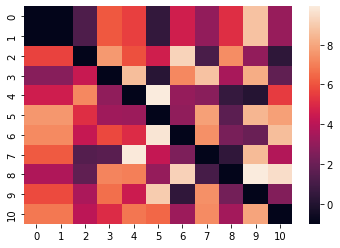

In [10]:
ext_dist_mx = extend_cost_mx(dist_mx, copy_n=1, to_copy_ix=0)
seq_vrp = list(range(1, ext_dist_mx.shape[0]))
filler_ixs = rng.choice(len(seq_vrp), size=len(seq_vrp) // 3, replace=False)

rng.shuffle(seq_vrp)
seq_vrp = [0] + seq_vrp + [0]
demands_vrpp = rng.integers(1, 4, size=len(seq_vrp)).tolist()
demands_irp = rng.uniform(0, 5, size=len(seq_vrp)).tolist()
quantities_irp = rng.uniform(0, 3, size=len(seq_vrp)).tolist()
import seaborn as sns

sns.heatmap(ext_dist_mx)
seq_vrp

In [11]:
dyn_costs = []
exp_t = win_span
while exp_t < T:
    wind_mx = rng.uniform(-max_wind_speed, max_wind_speed, size=ext_dist_mx.shape)
    eff_speed = wind_mx + speed
    eff_speed[eff_speed < 0] = 0
    np.fill_diagonal(wind_mx, fv)
    dyn_costs.append((eff_speed, exp_t))
    exp_t += win_span

In [12]:
ext_dist_mx.shape, dyn_costs[0][0].shape

((11, 11), (11, 11))

In [13]:
cost_calc_vrp(
    seq_vrp,
    dyn_costs,
    ext_dist_mx,
    initial_vx=0,
    forbidden_val=-1,
    ini_and_dummy_vxs={0, 1},
)

[27.96167853837877]

In [14]:
# TODO returns inf, print debug
cost_calc_vrpp(
    seq_vrp,
    dyn_costs,
    ext_dist_mx,
    initial_vx,
    fv,
    ini_and_dummy_vxs={0, 1},
    demands=demands_vrpp,
    fillval=-1,
)

[27.96167853837877, 17]

In [26]:
cost_calc_irp(
    seq_vrp,
    dyn_costs,
    ext_dist_mx,
    initial_vx,
    fv,
    ini_and_dummy_vxs={0, 1},
    demands=demands_irp,
    fillval=-1,
    quantities=quantities_irp,
    capacity=0.9 * sum(quantities_irp),
)

[27.96167853837877, 34.514540989326555]

## Schemas

In [35]:
import json
from pathlib import Path

In [36]:
with Path("data/environments/map_2021-12-15_09-13-30_vrp.json").open("r") as f:
    data = json.load(f)

In [39]:
data.keys()

dict_keys(['generation_setup', 'grid_size', 'speed', 'max_wind_speed', 'transition_prohibition_p', 'point_distance_std_dev', 'coords_creation', 'total_t', 'no_of_t_windows', 'max_demand', 'max_x', 'max_y', 'exp_label'])

In [42]:
gen_setup = data["generation_setup"]
gen_setup.keys()

dict_keys(['coords', 'distance_mx', 'dyn_costs', 'demands_sdvrp', 'demands_irp', 'demand_rewards'])

In [43]:
gen_setup["demands_sdvrp"]

[0, 6, 1, 6, 8, 8, 9, 6, 1, 1, 1, 9, 1, 1, 5, 7]

In [46]:
print(f"""[{", ".join(f"{d:.2f}" for d in gen_setup["demands_irp"])}]""")

[0.00, 1.06, 0.89, 0.45, 0.49, 1.10, 0.49, 0.38, 0.68, 0.55, 0.52, 0.93, 0.96, 0.24, 0.51, 0.74]


In [47]:
data["exp_label"]

'VRP'

In [10]:
import numpy as np

In [11]:
rng = np.random.default_rng()

In [12]:
from libs.optimizers.algorithms.simulated_annealing import simulated_annealing

In [13]:
N = 100


def f(x: np.ndarray) -> float:
    return np.square(x).sum()


bnds = np.array([[-10, 10]] * N)
initial_sol = rng.random(size=len(bnds)) * (bnds[:, 1] - bnds[:, 0])
print(f"{f(initial_sol) = }")
sol, sol_obj, info, rng = simulated_annealing(
    f, bnds, rng, step_max=1, iter_max=10000, initial_temp=5230, initial_sol=initial_sol
)
print(f"{sol_obj = }, {info = }")

f(initial_sol) = 14211.899871535197
sol_obj = 89.0107672542449, info = {'iterations': 10000}


In [14]:
%%timeit
simulated_annealing(
    f, bnds, rng, step_max=1, iter_max=10000, initial_temp=5230, initial_sol=initial_sol
)

96.1 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
from math import pow

In [16]:
from scipy.stats import rv_continuous


class cauchy_lorentz_visiting_distr(rv_continuous):
    "Gaussian distribution"

    def _pdf(self, x, qv: int, T: float, D: int):
        return pow(T, -D / (3 - qv)) / pow(
            1 + (qv - 1) * x * x / pow(T, 2 / (3 - qv)), 1 / (qv - 1) + 0.5 * (D - 1)
        )


gen = cauchy_lorentz_visiting_distr()

In [17]:
T = 5320
D = 30
qv = 2.5
x = 100000
pow(T, -D / (3 - qv)) / pow(
    1 + (qv - 1) * x * x / pow(T, 2 / (3 - qv)), 1 / (qv - 1) + 0.5 * (D - 1)
)

2.787267937983598e-224

In [18]:
foo = gen(qv=2.5, T=5320, D=3)

In [19]:
from scipy.stats import rv_continuous
from math import pi


class cauchy_distr(rv_continuous):
    "Gaussian distribution"

    def _pdf(self, x, a: float, T: float):
        aT = a * T
        return aT / (pi * aT * aT + x * x)


gen = cauchy_distr(seed=(1 << 32) - 1)
gen.rvs(a=1e-3, T=5320)

-53.945308970447094

In [20]:
import matplotlib.pyplot as plt
import numpy as np

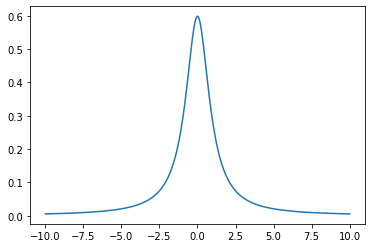

In [21]:
B = 10
xs = np.linspace(-B, B, 10000)
ys = np.fromiter((gen.pdf(x, a=1e-4, T=5320) for x in xs), dtype=np.float64)
plt.plot(xs, ys)

In [22]:
import sys

In [23]:
rng.integers(10)

9

In [24]:
1 << 32 == 2 ** 32

True

In [25]:
gen.rvs(a=1e-3, T=5320, size=10)

array([   0.43746448,   -1.64065174,   -1.79661854, -296.4494744 ,
          1.40206239,   -5.39169107,  -35.59144469,    0.38709854,
         -6.30432039,    1.66023703])

In [1]:
from libs.optimizers.algorithms.simulated_annealing import (
    generalized_simulated_annealing,
)
import numpy as np

rng = np.random.default_rng()

In [2]:
N = 100


def f(x: np.ndarray) -> float:
    return np.square(x).sum()


bnds = np.array([[-10, 10]] * N)
initial_sol = rng.random(size=len(bnds)) * (bnds[:, 1] - bnds[:, 0])
print(f"{f(initial_sol) = }")

sol, sol_obj, info, rng = generalized_simulated_annealing(
    f=f,
    bounds=bnds,
    rng=rng,
    iter_max=10,
    initial_temp=5230,
    initial_sol=initial_sol,
    early_stop_iters=100,
    alpha=0.9,
    beta=0.9,
    a=1e-3,
)
print(f"{sol_obj = }, {info = }")

f(initial_sol) = 14156.165435409499


C:\Users\obszansk\my\bachelor-thesis-project\.venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:1837: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._pdf, _a, x, args=args)[0]


sol_obj = 14156.165435409499, info = {'iterations': 10}


In [3]:
out = {"?": 42}


def f1():
    out["?"]


def f2():
    d = {"?": 42}
    d["?"]

In [6]:
%timeit f1()

66.9 ns ± 0.239 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [7]:
%timeit f2()

109 ns ± 1.34 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [16]:
import numpy as np
import seaborn as sns
from scipy.stats import poisson
import matplotlib.pyplot as plt

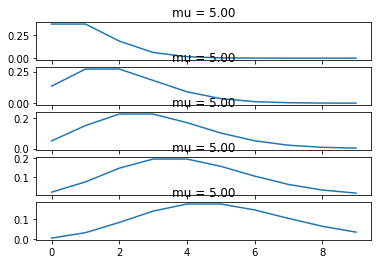

In [21]:
xs = np.arange(0, 10)
ys = []
for mu in range(1, 6):
    ys.append(poisson.pmf(xs, mu=mu))
fig, axs = plt.subplots(nrows=len(ys))
for ax, y in zip(axs, ys):
    sns.lineplot(x=xs, y=y, ax=ax)
    ax.set_title(f"{mu = :.2f}")